In [1]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
import time
import matplotlib.pyplot as plt
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pickle

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

### Gadf


# Record Audio

In [2]:
!pip install librosa

In [3]:
def feature_extractor(sound_path, win_length_ms=25, hop_length_ms=10):
    # Load the audio file
    signal, sr = librosa.load(sound_path,sr=8000)
    # signal,sr = wavfile.read(sound_path)
    # Extract MFCCs
    win_length_samples = int(sr * win_length_ms / 1000)
    hop_length_samples = int(sr * hop_length_ms / 1000)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, hop_length=hop_length_samples, win_length=win_length_samples)
    # mfccs = mfcc(signal,samplerate=sr,nfft = 2048,numcep=13,nfilt=13)
    
    #Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [4]:
def preprocess(path, is_pca=0, num_pca = 2, window_length_ms=20, hop_length_ms=10):
    '''
    Return the numpy array
    '''
    # Get the path of the audio file
    audio_file = Path(path)
    samples,sample_rate = librosa.load(audio_file,sr=8000)
    # print(f"The original samples are {samples.shape} and sample rate is {sample_rate}")
    # Remove silence at start and end
    # TODO: Apply VAD
    # samples_trimmed, _= librosa.effects.trim(samples, top_db=60)
    a, b, c, d = feature_extractor(audio_file,window_length_ms,hop_length_ms)
    # tot= np.concatenate((a,b,c,d)).T
    tot = d.T
          
    # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
    columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
    df = pd.DataFrame(tot, columns=columns)

    # Save the DataFrame to a CSV file
    #csv_filename = '{path}.csv'
    #df.to_csv(csv_filename, index=False)
    
    if(is_pca==1):
        pca = PCA(n_components=num_pca)
        components = pca.fit_transform(df)
        df = pd.DataFrame(data=components)
    df_new = df.to_numpy()
    return df_new

In [5]:
def preprocess_folder(folder_path, is_pca=0, num_pca=2, items=50,window_length_ms=20, hop_length_ms=10):
    '''
    Return a numpy array containing preprocessed data from all .wav files in the specified folder.
    '''
    # Initialize an empty list to store data from all files
    data_list = []
    i = 0
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if(i>items):
            break
        # Check if the file is a .wav file
        if file_name.endswith('.wav'):
            # Get the full path of the audio file
            audio_file = os.path.join(folder_path, file_name)
            # samples, sample_rate = librosa.load(audio_file, sr=16000)
            #print(f"Processing {audio_file}: original samples are {samples.shape} and sample rate is {sample_rate}")

            # Remove silence at start and end
            # samples_trimmed, _ = librosa.effects.trim(samples, top_db=60)
            a, b, c, d = feature_extractor(audio_file)
            # tot = np.concatenate((a, b, c, d)).T
            tot = d.T

            # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
            columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
            df = pd.DataFrame(tot, columns=columns)

            if is_pca == 1:
                pca = PCA(n_components=num_pca)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)

            # Append the DataFrame to the list
            data_list.append(df)
        i += 1

    # Concatenate all DataFrames in the list to create a single DataFrame
    concatenated_df = pd.concat(data_list, ignore_index=True)
    
    # Convert the DataFrame to a numpy array
    array_data = concatenated_df.to_numpy()
    
    return array_data

# Main Code

In [6]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

In [7]:
train_paths = ["/kaggle/input/language-recognition/Language-Recognition-VADaudio/Gujrati-Train","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Tamil-Train","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Telugu-Train"]
test_paths = ["/kaggle/input/language-recognition/Language-Recognition-VADaudio/Gujrati-Test","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Tamil-Test","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Telugu-Test"]

In [8]:
import math
from scipy.stats import multivariate_normal
import numpy as np


In [9]:
class GMMNew:
    def __init__(
        self, 
        n_mixtures=120, 
        max_iter=100, 
        covar_type='full', 
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.log_likelihood_plot_list = None
        
    # get aic and bic score
    def aic_bic(self, X):
        # Get the log-likelihood
        log_likelihood = self.get_loglikelihood(X)
        
        # Calculate the number of parameters in the model
        n_params = self.n_mixtures
        
        # Calculate AIC and BIC
        aic = -2 * log_likelihood + 2 * n_params
        bic = -2 * log_likelihood + n_params * np.log(len(X))
        
        return aic, bic
    
    
    # Function to get the log likelihood
    def get_loglikelihood(self,X):
        return self.get_score(X)
    
        # Function to basically get log-likelihood data
    def get_score(self,X):
        resp = np.zeros((len(X), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian (wik) probability of a data point i to be in kth Gaussian mixture 
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * multivariate_normal(mean=self.means[i], cov=self.covs[i],allow_singular=True).pdf(X)
        return np.mean(np.log(resp.sum(axis=1)))
    
    # M Step for full covariance matrix
    def full_covar(self, X, resp):
        d = X.shape[1]
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = X - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i] += np.eye(d) * 1e-6
        return new_covs
    
    # M step for diagonal covariance matrix
    def diag_covar(self, X, resp):
        d = X.shape[1]
        new_covs = np.zeros((self.n_mixtures, d,d))
        for i in range(self.n_mixtures):
            wik = resp[:,i]
            num = wik.reshape(X.shape[0],1)*np.square(X-self.means[i])
            column_sums = np.sum(num,axis=0).reshape(1,d) # result will be (1,d) matrix
            column_sums /= np.sum(wik)
            np.fill_diagonal(new_covs[i],column_sums+1e-6) # regularisation term
        return new_covs
    
    # E step
    def e_step(self, X):
        resp = np.zeros((len(X), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * multivariate_normal(mean=self.means[i], cov=self.covs[i],allow_singular=True).pdf(X)
        # To plot the variation of log_likelihood
        self.log_likelihood_plot_list.append(np.mean(np.log(resp.sum(axis=1))))
        resp = resp / resp.sum(axis=1).reshape(-1, 1)
        return resp
    
    def m_step(self, X, resp):        
        # M step for alphas
        new_alphas = resp.mean(axis=0)
        
        # M step for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i].reshape(-1, 1), X).sum(axis=0) / resp[:, i].sum()
        
        # M step for covariance matrix according to type chosen
        if self.covar_type == 'full':
            new_covs = self.full_covar(X, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(X, resp)
        return new_alphas, new_means, new_covs
    
    # Fit algorithm
    def fit(self, X):
        total_iteration_time = 0
        
        start_total = time.time()
        d = X.shape[1]
        last = 0
        # To store the log lijkelihood for every iteration
        self.log_likelihood_plot_list = []
        
        # initialize means as to K means result initally
        kmeans_model =  KMeans(self.n_mixtures).fit(X)
        self.means = kmeans_model.cluster_centers_
        
        # initialize cov matrix of data point i as sample covariance matrix
        self.covs = np.zeros((self.n_mixtures, d, d))
        data_labels = kmeans_model.labels_

        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(X[data_labels == i].T+0.1)
        
        # EM - algorithm
        for epoch in range(self.max_iter):
            last = epoch
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(X)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(X, resp)
            
            # Print convergence criteria
            if (np.abs(self.alphas - alphas) < 1e-4).all() and \
               (np.abs(self.means - means) < 1e-4).all() and \
               (np.abs(self.covs - covs) < 1e-4).all():
                print("Converged at iteration:", step)
                break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]
        end_total = time.time()
        total_time = end_total - start_total
        print(f"Average time per iteration: {total_time / (self.max_iter):.4f} seconds")
        plt.figure(figsize=(6, 4)) 
        plt.plot(range(last), self.log_likelihood_plot_list,color='g', linewidth=2)
        plt.xlabel('Number of Iteration')
        plt.ylabel('Log Likelihood')
        plt.title('Variation of Log Likelihood for each iteration')
        plt.tight_layout()  
        plt.show()
        

# Pipeline to train the model and plot the Confusion Matrix and get metrics

In [10]:
# Function to get f1 score
def compute_f1_score(confusion_matrix):
    num_classes = len(confusion_matrix)
    f1_scores = []

    for i in range(num_classes):
        true_positive = confusion_matrix[i][i]
        false_positive = sum(confusion_matrix[j][i] for j in range(num_classes) if j != i)
        false_negative = sum(confusion_matrix[i][j] for j in range(num_classes) if j != i)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1_score)

    return f1_scores

In [11]:
# Calculate the silhoutte score
def calc_silhoutte_score(X,gmms):
    # Iterate through each data point in X and assign cluster labels
    cluster_labels_list = []
    for x in X:
        log_likelihood = [gmm.get_score(x) for gmm in gmms]  # Calculate log-likelihood for each GMM
        predicted_cluster = np.argmax(log_likelihood)  # Assign to cluster with maximum log-likelihood
        cluster_labels_list.append(predicted_cluster)

    # Convert cluster labels to numpy array
    cluster_labels = np.array(cluster_labels_list)

    # Compute silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def pipeline(n_components_gmm, is_pca, num_pca, c_type='full'):
    gmms = []
    sklearn_gmms = []  # List to store scikit-learn's GMMs
    i = 0
    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']
    
    for path in train_paths:
        i += 1
        X = preprocess_folder(path, is_pca, num_pca, items=110)
        
        # Train and save your GMM
        gmm = GMMNew(n_components_gmm, 100, c_type)  # Max 100 iterations
        gmm.fit(X)
        with open(f'gmm{c_type}_{n_components_gmm}_{num_pca}_{i}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        gmms.append(gmm)
        
        # Train scikit-learn's GMM
        sklearn_gmm = GaussianMixture(n_components=n_components_gmm, covariance_type=c_type, max_iter=100)
        sklearn_gmm.fit(X)
        sklearn_gmms.append(sklearn_gmm)
        aic, bic = gmm.aic_bic(X)
        print(f"GMM Model for {class_labels[(i-1)%3]} => AIC: {aic}, BIC: {bic}")
        print(f"{class_labels[(i-1)%3]} is done")

    # Initialize confusion matrices
    confusion_matrix_gmm = np.zeros((3, 3))  # For your GMM
    confusion_matrix_sklearn = np.zeros((3, 3))  # For scikit-learn's GMM

    # Evaluate your GMM and update confusion matrix
    for idx, path in enumerate(test_paths):
        class_counts_gmm = {0: 0, 1: 0, 2: 0}
        class_counts_sklearn = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file, is_pca, num_pca)
                
                # Evaluate your GMM
                log_likelihood_gmm = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm = gmms[i]  
                    log_likelihood_gmm[i] = gmm.get_score(vector)
                
                winner_gmm = np.argmax(log_likelihood_gmm)
                class_counts_gmm[winner_gmm] += 1

                # Evaluate scikit-learn's GMM
                log_likelihood_sklearn = np.zeros(len(sklearn_gmms))
                for i in range(len(sklearn_gmms)):
                    gmm = sklearn_gmms[i]
                    log_likelihood_sklearn[i] = np.array(gmm.score(vector)).sum()

                winner_sklearn = np.argmax(log_likelihood_sklearn)
                class_counts_sklearn[winner_sklearn] += 1

        # Update confusion matrices
        for true_label, count in class_counts_gmm.items():
            confusion_matrix_gmm[idx, true_label] = count
        for true_label, count in class_counts_sklearn.items():
            confusion_matrix_sklearn[idx, true_label] = count


    # Plot confusion matrices side by side
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix_gmm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for GMM implementation')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix_sklearn, annot=True, cmap='Oranges', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix for Scikit learn implementation")

    plt.show()

    # Calculate and print accuracy and F1 scores
    accuracy_gmm = np.trace(confusion_matrix_gmm) / np.sum(confusion_matrix_gmm)
    accuracy_sklearn = np.trace(confusion_matrix_sklearn) / np.sum(confusion_matrix_sklearn)
    
    f1_scores_gmm = compute_f1_score(confusion_matrix_gmm)
    f1_scores_sklearn = compute_f1_score(confusion_matrix_sklearn)
    
    print("GMM Implementation Metrics:")
    print(f"Overall Accuracy: {accuracy_gmm*100:.2f}%")
    for idx, label in enumerate(class_labels):
        print(f"F1 Score of {label}: {f1_scores_gmm[idx]}")

    print("\nScikit-learn's GMM Metrics:")
    print(f"Overall Accuracy: {accuracy_sklearn*100:.2f}%")
    for idx, label in enumerate(class_labels):
        print(f"F1 Score of {label}: {f1_scores_sklearn[idx]}")
        

## Getting the results

Num comp:256, Num PCA:24
Average time per iteration: 6.5218 seconds


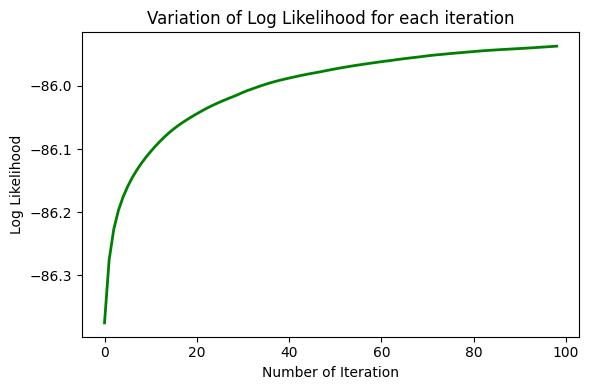

GMM Model for Gujrati => AIC: 683.8734937103658, BIC: 2936.9511620529015
Gujrati is done
Average time per iteration: 7.1584 seconds


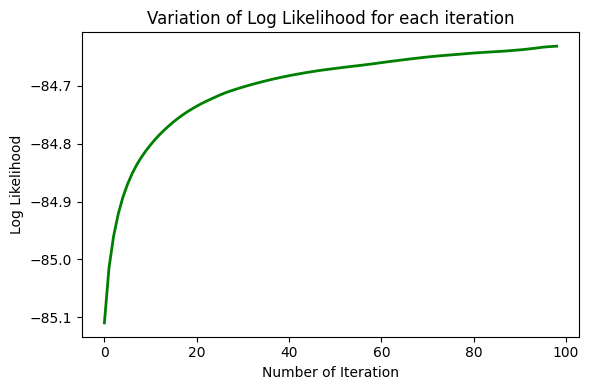

GMM Model for Tamil => AIC: 681.2619402282005, BIC: 2962.6106667492886
Tamil is done
Average time per iteration: 5.7266 seconds


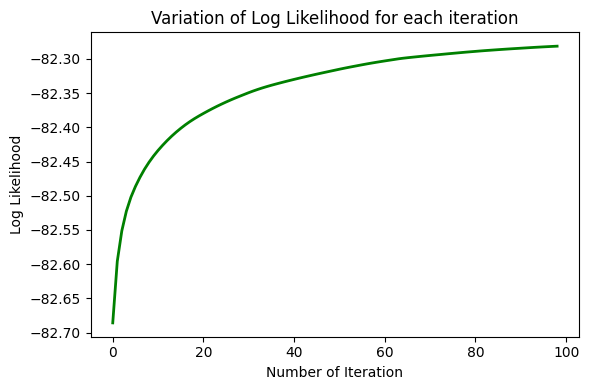

GMM Model for Telugu => AIC: 676.562185562274, BIC: 2900.796672912919
Telugu is done


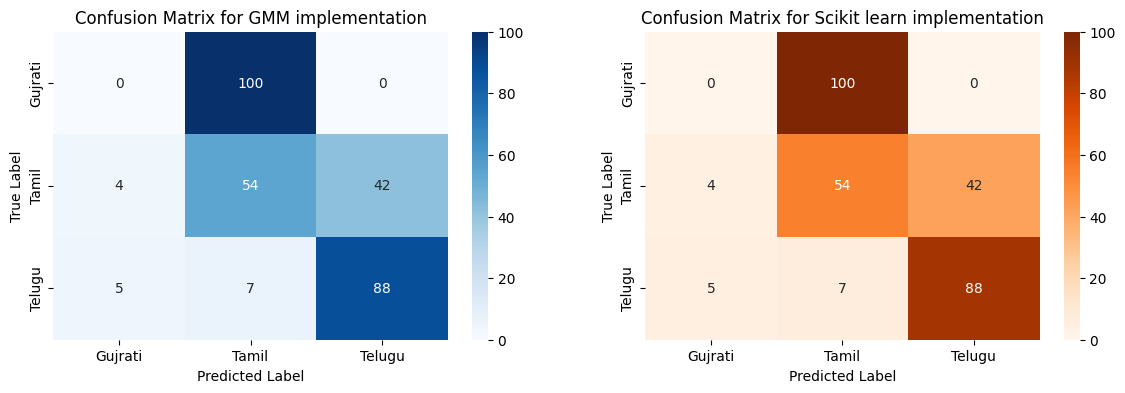

GMM Implementation Metrics:
Overall Accuracy: 47.33%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.4137931034482759
F1 Score of Telugu: 0.7652173913043478

Scikit-learn's GMM Metrics:
Overall Accuracy: 47.33%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.4137931034482759
F1 Score of Telugu: 0.7652173913043478


In [13]:
import warnings
warnings.filterwarnings("ignore")

n_comp_list = [256]
num_pca_list = [24]
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand,'diag')

Num comp:256, Num PCA:24
Average time per iteration: 10.1073 seconds


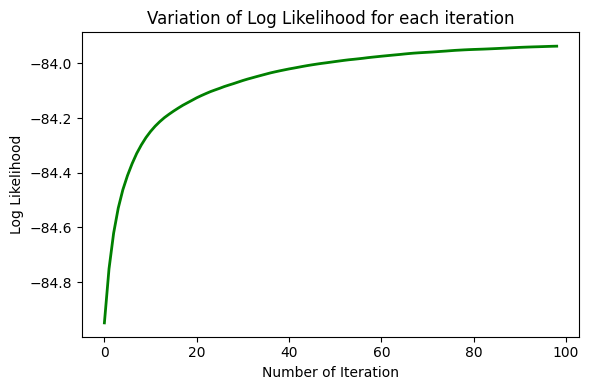

GMM Model for Gujrati => AIC: 679.8731397446952, BIC: 2932.950808087231
Gujrati is done
Average time per iteration: 12.1270 seconds


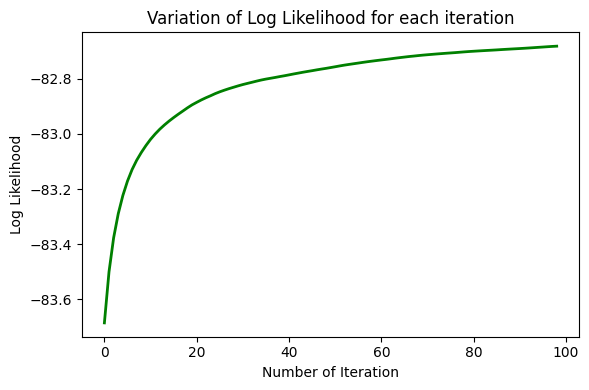

GMM Model for Tamil => AIC: 677.3620916990867, BIC: 2958.7108182201746
Tamil is done
Average time per iteration: 8.5358 seconds


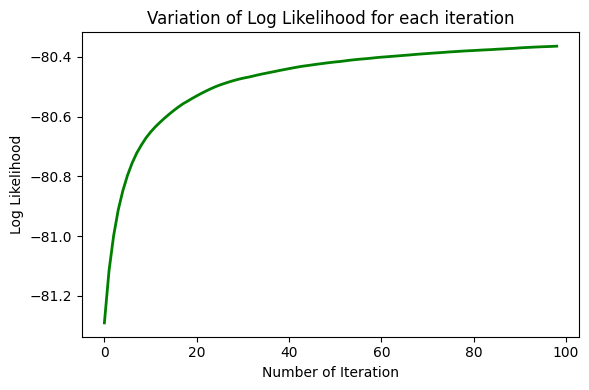

GMM Model for Telugu => AIC: 672.7264077855831, BIC: 2896.960895136228
Telugu is done


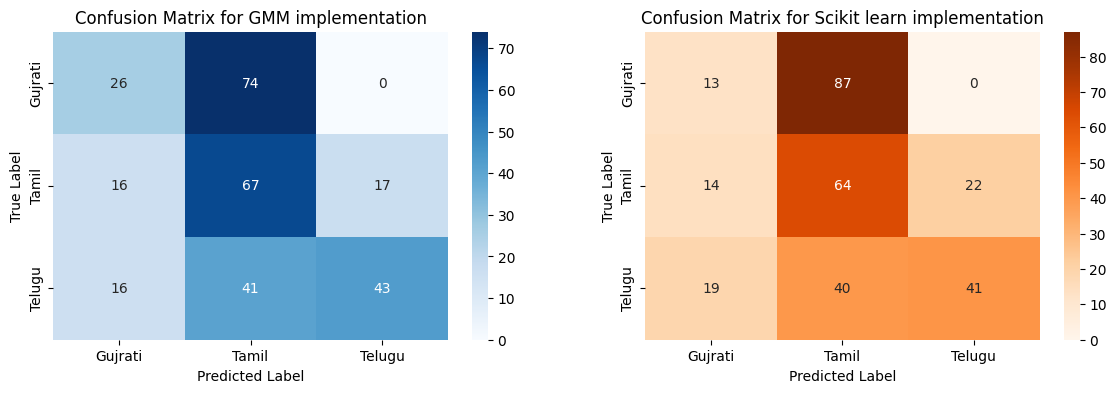

GMM Implementation Metrics:
Overall Accuracy: 45.33%
F1 Score of Gujrati: 0.3291139240506329
F1 Score of Tamil: 0.4751773049645391
F1 Score of Telugu: 0.5375

Scikit-learn's GMM Metrics:
Overall Accuracy: 39.33%
F1 Score of Gujrati: 0.1780821917808219
F1 Score of Tamil: 0.4398625429553265
F1 Score of Telugu: 0.5030674846625766


In [14]:
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand,'full')